In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector, Operator, Pauli

#from qiskit_ibm_runtime import QiskitRuntimeService, Session
#from qiskit_ibm_runtime import EstimatorV2 as Estimator

import warnings
warnings.filterwarnings('ignore')
import uuid


In [29]:
# To run on hardware, select the backend with the fewest number of jobs in the queue

#service = QiskitRuntimeService(channel = 'ibm_quantum',token='YOUR_TOKEN') 

#backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
#print(f"Selected backend: {backend.name}")

Theta : 0.0000, Max S Value: 1.4142
Theta : 0.2565, Max S Value: 1.7729
Theta : 0.5129, Max S Value: 2.1082
Theta : 0.7694, Max S Value: 2.3981
Theta : 1.0258, Max S Value: 2.6236
Theta : 1.2823, Max S Value: 2.7700
Theta : 1.5387, Max S Value: 2.8277
Theta : 1.7952, Max S Value: 2.7930
Theta : 2.0517, Max S Value: 2.6681
Theta : 2.3081, Max S Value: 2.4611
Theta : 2.5646, Max S Value: 2.1857
Theta : 2.8210, Max S Value: 1.8598
Theta : 3.0775, Max S Value: 1.5048
Theta : 3.3339, Max S Value: 1.1439
Theta : 3.5904, Max S Value: 0.8006
Theta : 3.8468, Max S Value: 0.4975
Theta : 4.1033, Max S Value: 0.2543
Theta : 4.3598, Max S Value: 0.0870
Theta : 4.6162, Max S Value: 0.0065
Theta : 4.8727, Max S Value: 0.0181
Theta : 5.1291, Max S Value: 0.1210
Theta : 5.3856, Max S Value: 0.3085
Theta : 5.6420, Max S Value: 0.5684
Theta : 5.8985, Max S Value: 0.8835
Theta : 6.1550, Max S Value: 1.2334
Theta : 6.4114, Max S Value: 1.5951
Theta : 6.6679, Max S Value: 1.9449
Theta : 6.9243, Max S Value:

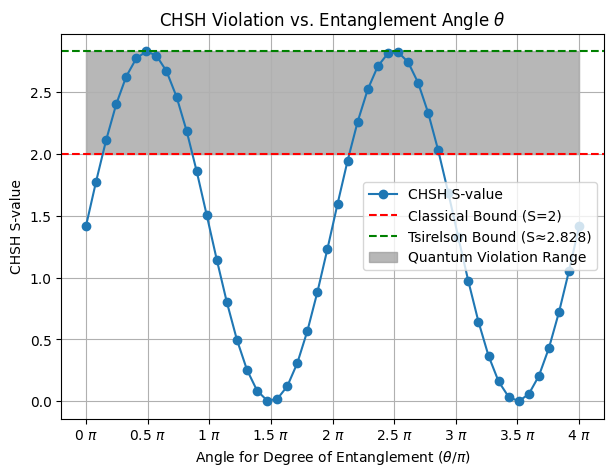

In [30]:
##############################################################################
# Create Parameterized Entangled State, quantum circuit, create a bell state
# and then apply parametrized ry(theta) to one qubit
##############################################################################
def create_entangled_state(theta):
    qc = QuantumCircuit(2)
    qc.ry(theta, 0)
    qc.cx(0, 1)
    
    return qc
    
##############################################################################
# Measure Correlation <Z Z> after Local Rotations --> returns a real number 
# between +1 and -1 that indicates how correlated (positively or negatively) 
# the two qubits are when measured in the chosen local bases
##############################################################################
def measure_correlation(state, angle_qubit_0, angle_qubit_1):
    """
    `angle_qubit_0` and `angle_qubit_1`
    correspond to rotations about the Y-axis before measuring Z,
    effectively letting us measure along different axes
    """
    # Define R_y(angle) manually as a 2x2 matrix
    # R_y(angle) = [[cos(angle/2), -sin(angle/2)],
    #               [sin(angle/2),  cos(angle/2)]]
    rotation_0 = Operator([
        [np.cos(angle_qubit_0/2), -np.sin(angle_qubit_0/2)],
        [np.sin(angle_qubit_0/2),  np.cos(angle_qubit_0/2)]
    ])
    rotation_1 = Operator([
        [np.cos(angle_qubit_1/2), -np.sin(angle_qubit_1/2)],
        [np.sin(angle_qubit_1/2),  np.cos(angle_qubit_1/2)]
    ])
    
    # Apply local R_y rotations
    rotated_state = state.evolve(rotation_0, [0]).evolve(rotation_1, [1])
    
    # Use Pauli('ZZ') to measure Z \otimes Z on the rotated state
    correlation = np.real(rotated_state.expectation_value(Pauli('ZZ')))
    return correlation

##############################################################################
# 3. Compute the CHSH S-value
##############################################################################
def chsh_s_value(state, angles):
    """
    Given a quantum state and a dictionary of angles:
      angles = {
          'A1': float,
          'A2': float,
          'B1': float,
          'B2': float
      }
    measure:
       S = | <A1 B1> + <A1 B2> + <A2 B1> - <A2 B2> |
    where <A1 B1> means the correlation <Z Z> 
    after rotating each qubit by A1, B1.
    """
    A1B1 = measure_correlation(state, angles['A1'], angles['B1'])
    A1B2 = measure_correlation(state, angles['A1'], angles['B2'])
    A2B1 = measure_correlation(state, angles['A2'], angles['B1'])
    A2B2 = measure_correlation(state, angles['A2'], angles['B2'])
    S = np.abs(A1B1 + A1B2 + A2B1 - A2B2)
    return S

##############################################################################
# Choose measurement angles (canonical choice for maximum violation)
# Typically, the optimal CHSH angles for a singlet-like Bell state are:
# A1 = 0, A2 = pi/2, B1 = pi/4, B2 = -pi/4 (or a close variant).
# Each entangled state has its own set of optimal CHSH angles, 
# so you can tweak them as needed.
##############################################################################
angles = {
    'A1': 0.0,
    'A2': np.pi / 2,
    'B1': np.pi / 4,
    'B2': -np.pi / 4
}

thetas = np.linspace(0, 4*np.pi, 50)
circuits = []
theta_labels = []

# Use the statevector simulator
backend = Aer.get_backend('statevector_simulator')

# Build circuits
for i, theta in enumerate(thetas):
    qc = create_entangled_state(theta)
    # unique circuit name to avoid collisions, idk i had a bunch of errors so i had to implrmrnt this, im sure you can get around it aswell
    qc.name = f"theta_{i}_{uuid.uuid4()}"  
    
    # Provide a unique label for saving the statevector
    qc.save_statevector(label=f"my_sv_{i}")

    circuits.append(qc)
    theta_labels.append(theta)


# Transpile
transpiled_circuits = transpile(circuits, backend=backend, optimization_level=3)
# Use Qiskit Runtime Session for hardware execution
#with Session(service=service, backend=backend) as session:
    #estimator = Estimator(session=session)
    #job = estimator.run(circuits=transpiled_circuits)
    #result = job.result()

#Run
job = backend.run(transpiled_circuits)
result = job.result()

# Extract S-values
s_vals = []
for i, theta in enumerate(theta_labels):
    # Retrieve circuit name
    qc_name = transpiled_circuits[i].name
    
    # Retrieve dictionary containing data for this circuit
    data_dict = result.data(qc_name)
    
    # Extract the statevector from our unique label
    state_vector = data_dict[f"my_sv_{i}"]
    
    # Convert to a Statevector object
    state = Statevector(state_vector)
    
    # Compute CHSH S-value
    S = chsh_s_value(state, angles)
    s_vals.append(S)
    # Print results for this theta
    print(f"Theta : {theta:.4f}, Max S Value: {S:.4f}")

# Normalize theta values by dividing by pi                                                                           why?                                                                          why? 
normalized_thetas = thetas/ np.pi

# Plot Results with Updated Formatting
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(normalized_thetas, s_vals, 'o-', label='CHSH S-value')
ax.axhline(y=2, color='r', linestyle='--', label='Classical Bound (S=2)')
ax.axhline(y=2.828, color='g', linestyle='--', label='Tsirelson Bound (S≈2.828)')
ax.fill_between(normalized_thetas, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7, label="Quantum Violation Range")

# Format x-axis ticks
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5)) # Every 0.5 π

plt.xlabel('Angle for Degree of Entanglement ($\\theta / \\pi$)')
plt.ylabel('CHSH S-value')
plt.title('CHSH Violation vs. Entanglement Angle $\\theta$')
plt.legend()
plt.grid(True)
plt.savefig('CHSH_violation_plot.png')
plt.show()